In [1]:
# http://sgjp.pl/morfeusz/dopobrania.html.en
# https://bulldogjob.pl/news/650-przeglad-pakietu-datatable-pythona

In [11]:
selected_labels = ['replies_cat']
# ['rage_cat', 'joy_cat', 'surprise_cat', 'fear_cat', 'sadness_cat']
selected_features = ['title', 'media_desc', 'highlight', 'division']
# ['title', 'media_desc', 'highlight', 'division', 'content']
normalize_emotion_label = None
# 'cut', 'multiply', None, 'weights'
input_articles = 'lemmatized_articles.csv' # lemmatized_articles.csv

In [12]:
import pandas as pd
from unidecode import unidecode
from collections import Counter
import numpy as np

In [13]:
articles = pd.read_csv('data/'+input_articles, nrows = 20000)

In [14]:
articles.head(1)

,content,division,highlight,media_desc,title,url
0,najwyzsza izba kontrola zwracac uwage problem ...,zus emerytura,tysiace polakow zanizone emerytura wystapilo z...,osoba maja dopisac skladek emerytalny czas stu...,nik alarmowac polak maja zanizone emerytura,"http://wyborcza.biz/biznes/7,147880,23632593,n..."


In [15]:
len(articles)

19087

In [16]:
articles = articles.dropna()

In [17]:
len(articles)

19056

## Prepare input for model

In [18]:
def concat_x_string(columns):
    a = pd.Series('', index = articles.index)
    for column in columns:
        a = a + articles[column] + ' '
    return a.str.strip().str.split(' ').values

##### Chose columns for model input

In [19]:
string_columns = concat_x_string(selected_features)

In [20]:
idf = dict(Counter([word for content in string_columns for word in content]))

In [21]:
filtered_idf = {word: freq for word, freq in idf.items() if freq > 3}

In [22]:
word_freq_df = pd.DataFrame(list(dict({word: freq for word, freq in idf.items()}).items()), columns = ['word', 'freq'])

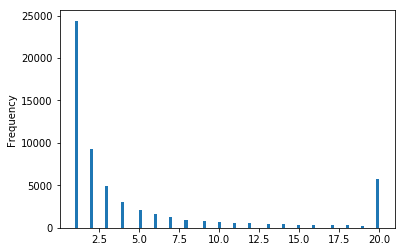

In [24]:
word_freq_df['cleaned_freq'] = word_freq_df['freq']
word_freq_df.loc[word_freq_df['freq'] > 20, 'cleaned_freq'] = 20

word_freq_df\
    ['cleaned_freq']\
    .plot(kind = 'hist', bins = 100)

##### Ignore words which appear very rare - they won't be very useful (and dataset won't fit into my ram)

In [25]:
# I want only words which appear in number of 0.1% times number of articles
def filter_not_frequent(string_columns, filtered_idf):
    filtered = []
    for record in string_columns:
        filtered.append([word for word in record if word in filtered_idf.keys()])
    return filtered

In [26]:
filtered = filter_not_frequent(string_columns, filtered_idf)

In [27]:
# with open('models/input_words_emotions', 'w') as f:
#     f.write("\n".join(unique_words))

In [28]:
unique_words = list(set(filtered_idf.keys()))
vocab_size = len(unique_words)

In [29]:
vocab_size

19730

In [30]:
word2int = {}
int2word = {}

for i,word in enumerate(unique_words):
    word2int[word] = i
    int2word[i] = word

##### Change words to vectors

In [31]:
def string_x_to_tf_idf(records, idf, vocab_size, word2int):
    dataset = []
    for record in records:
        tmp_vector = np.zeros(vocab_size)
        for word, counter in Counter(record).items():
            tmp_vector[word2int[word]] = counter / idf[word]
        dataset.append(tmp_vector)
    
    return np.asarray(dataset)

In [32]:
x = string_x_to_tf_idf(filtered, filtered_idf, vocab_size, word2int)

In [33]:
len(x)

19056

In [34]:
len(articles['url'])

19056

## Prepare labels

In [35]:
from labeling.emotions import rage, joy, sadness, surprise, fear, all_flag_words

In [36]:
comments_raw = pd.concat([
    pd.read_csv('data/processed_comments_1.csv'),
    pd.read_csv('data/processed_comments_2.csv')
])[['url', 'downvotes', 'upvotes', 'words']]

In [37]:
comments_raw.head(1)

,url,downvotes,upvotes,words
0,"http://wyborcza.biz/biznes/7,147880,23632593,n...",0,10,"['brak', 'kwartalnych', 'waloryzacji', 'kapita..."


In [38]:
comment_emotions = []
for comment in comments_raw['words'].values:
    record_labels = [0, 0, 0, 0, 0, 0]
    eval_comment = eval(comment)
    
    for i, emotion in enumerate([rage, joy, sadness, surprise, fear]):
        for flag_word in emotion:
            if flag_word in eval_comment:
                record_labels[i] += 1
        if record_labels[i] != 0:
            record_labels[5] += 1
                
    comment_emotions.append(record_labels)

In [39]:
emotions_df = pd.DataFrame(comment_emotions, index = comments_raw.index)
emotions_df.columns = ['rage', 'joy', 'sadness', 'surprise', 'fear', 'emotions_count']

In [40]:
comments = pd.concat([comments_raw, emotions_df], axis = 1).drop('words', axis = 1)

In [41]:
comments[comments['url'] == 'http://bialystok.wyborcza.pl/bialystok/7,35241,23042200,komorowski-budowanie-dumy-z-polskiej-historii-konczy-sie-wstydem.html']

,url,downvotes,upvotes,rage,joy,sadness,surprise,fear,emotions_count
221003,"http://bialystok.wyborcza.pl/bialystok/7,35241...",2,14,0,0,0,0,0,0
221004,"http://bialystok.wyborcza.pl/bialystok/7,35241...",9,6,0,0,0,0,0,0
221005,"http://bialystok.wyborcza.pl/bialystok/7,35241...",8,1,0,0,0,0,0,0
221006,"http://bialystok.wyborcza.pl/bialystok/7,35241...",1,4,0,0,0,0,0,0


In [42]:
sums = comments\
    .groupby('url')\
    .sum()

In [43]:
counts = comments\
    [['url', 'downvotes']]\
    .groupby('url')\
    .count()
counts.columns = ['replies']

In [44]:
labels = pd.concat([counts, sums], axis = 1)\
    .reindex(articles['url'])\
    .reset_index()\
    .drop('url', axis = 1)

In [45]:
labels['reactions'] = labels['upvotes'] + labels['downvotes']

In [46]:
len(labels)

19056

In [47]:
labels.head(1)

,replies,downvotes,upvotes,rage,joy,sadness,surprise,fear,emotions_count,reactions
0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [48]:
# Remove extreme values
labels.loc[labels['replies'] > 200, 'replies'] = 200
labels.loc[labels['downvotes'] > 500, 'downvotes'] = 500
labels.loc[labels['upvotes'] > 4000, 'upvotes'] = 4000
labels.loc[labels['reactions'] > 4500, 'reactions'] = 4500

In [49]:
# Add categorized labels
labels.loc[labels['replies'] < 7, 'replies_cat'] = -1
labels.loc[(labels['replies'] <= 25)&(labels['replies'] >= 7), 'replies_cat'] = 0
labels.loc[labels['replies'] > 25, 'replies_cat'] = 1

labels.loc[labels['reactions'] < 30, 'reactions_cat'] = -1
labels.loc[(labels['reactions'] <= 200)&(labels['reactions'] >= 30), 'reactions_cat'] = 0
labels.loc[labels['reactions'] > 200, 'reactions_cat'] = 1

means_for_balance = []
for emotion in ['rage', 'joy', 'sadness', 'surprise', 'fear']:
    labels.loc[labels[emotion] > 0 , emotion+'_cat'] = 1
    labels.loc[labels[emotion] == 0, emotion+'_cat'] = -1
    means_for_balance.append(len(labels[labels[emotion] != 1])/len(labels[labels[emotion] == 1]))

In [50]:
# labels[(labels['rage']!=0)&
#        (labels['joy']!=0)&
#        (labels['sadness']!=0)&
#        (labels['surprise']!=0)&
#        (labels['fear']!=0)]

In [51]:
# labels\
#     .groupby('fear_cat')\
#     .count()\
#     .plot(kind = 'bar')

In [52]:
less_class_count = len(labels[labels[selected_labels[0]] == 1])
labels_train = labels[labels[selected_labels[0]] == 1].iloc[:int(0.9*less_class_count)]
labels_test = labels[labels[selected_labels[0]] == 1].iloc[int(0.9*less_class_count):]

In [53]:
b = int(len(labels) * 0.9)

In [54]:
#if selected_labels[0] in ['rage_cat', 'joy_cat', 'surprise_cat', 'fear_cat', 'sadness_cat']:
if normalize_emotion_label == 'cut':
    l = len(labels[labels[selected_labels[0]] == 1])
    labels = pd.concat([
        labels[labels[selected_labels[0]] == 1],
        labels[labels[selected_labels[0]] == -1].iloc[:l]
    ])
elif normalize_emotion_label == 'multiply':
    m = int(len(labels[labels[selected_labels[0]] == -1])/len(labels_train))
    labels_norm = pd.concat([
        labels_train for x in range(m)
    ] + [labels[labels[selected_labels[0]] == -1]])
else:
    labels_norm = labels.iloc[:b]
    labels_test = labels.iloc[b:]

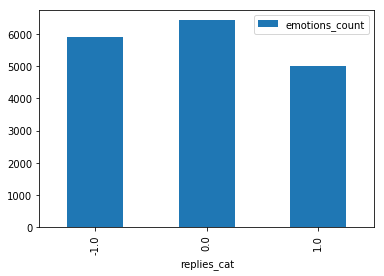

In [55]:
labels\
    .groupby(selected_labels[0])\
    .count()\
    [['emotions_count']]\
    .plot(kind = 'bar')

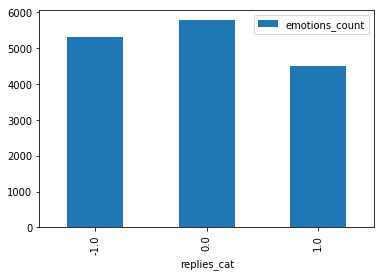

In [56]:
labels_norm\
    .groupby(selected_labels[0])\
    .count()\
    [['emotions_count']]\
    .plot(kind = 'bar')

## Merge x and y

In [57]:
labels_norm = labels_norm.sample(frac=1)
labels_test = labels_test.sample(frac=1)

In [58]:
labels_indices_train = labels_norm[labels_norm['reactions'].isna() == False].index.values
labels_indices_test = labels_test[labels_test['reactions'].isna() == False].index.values

In [59]:
labels_train = labels_norm[labels_norm['reactions'].isna() == False]

In [60]:
train_x = x[labels_indices_train]
train_y = labels_norm[labels_norm['reactions'].isna() == False][selected_labels[0]].values

test_x = x[labels_indices_test]
test_y = labels_test[labels_test['reactions'].isna() == False][selected_labels[0]].values

In [61]:
print(train_x.shape, train_y.shape)

(15591, 19730) (15591,)


In [62]:
print(test_x.shape, test_y.shape)

(1736, 19730) (1736,)


## Training

In [63]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu

In [64]:
inputs = Input(shape = (vocab_size, ))

In [65]:
hidden_1 = Dense(vocab_size/40, activation = relu)(inputs)
hidden_2 = Dense(vocab_size/50, activation = relu)(hidden_1)

W0627 21:58:24.377682 139750043383552 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [66]:
outputs = Dense(len(selected_labels))(hidden_2)

In [67]:
model = Model(
    inputs = inputs,
    outputs = outputs
)

In [68]:
from tensorflow.keras.optimizers import RMSprop

In [69]:
optimizer = RMSprop(0.003)

In [70]:
from tensorflow.losses import *

In [71]:
selected_labels

['replies_cat']

In [72]:
weights = [1,1]

In [73]:
if normalize_emotion_label == 'weights':
    weights = labels\
        [labels['reactions'].isna() == False]\
        .groupby(selected_labels[0])\
        .count()\
        [labels.columns[0]]\
        .values
    weights = [x/max(weights) for x in weights]

In [74]:
# my_losses = 0
# for i, selected_label in enumerate(selected_labels):
#     my_losses.append(
#         mean_squared_error(labels = train_y[:,i], predictions = model.predict(train_x)[:,i])
#     )

In [75]:
#mean_squared_error(labels = train_y[:,i], predictions = model.predict(train_x)[:,i]) + mean_squared_error(labels = train_y[:,i], predictions = model.predict(train_x)[:,i])

In [76]:
model.compile(
    loss=mean_squared_error,
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

W0627 21:58:24.709795 139750043383552 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [77]:
example_batch = test_x[:5]
print(model.predict(example_batch))

[[ 8.4860215e-04]
 [ 7.6769979e-04]
 [-4.5649312e-04]
 [-7.3988456e-05]
 [ 1.5090671e-03]]


In [78]:
EPOCHS = 300

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [81]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19730)]           0         
_________________________________________________________________
dense (Dense)                (None, 493)               9727383   
_________________________________________________________________
dense_1 (Dense)              (None, 394)               194636    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 395       
Total params: 9,922,414
Trainable params: 9,922,414
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(
    train_x, train_y,
    epochs=EPOCHS,
    validation_split = 0.2, 
    verbose=0,
    callbacks=[early_stop],
    class_weight = list(reversed(weights))
)

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [85]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [86]:
mae

0.6208457

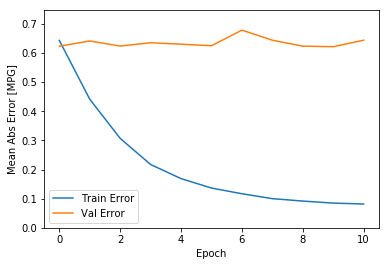

In [87]:
plot_history(history)

In [88]:
pred = model.predict(test_x)

In [89]:
res = pd.concat([pd.DataFrame(pred), pd.DataFrame(test_y)], axis = 1)

In [90]:
res.columns = ["pred_"+x for x in selected_labels] + ["real_"+x for x in selected_labels]

In [91]:
res.sample(frac=1).head(10)

,pred_replies_cat,real_replies_cat
1016,-0.618963,-1.0
547,-0.133656,0.0
212,-0.087136,-1.0
1420,0.020940,-1.0
9,-0.332778,-1.0
1086,0.968310,0.0
880,0.677294,0.0
772,-0.586873,0.0
392,0.087584,0.0
231,-1.056373,-1.0


In [92]:
from sklearn.metrics import confusion_matrix

In [93]:
res_labels = res
for emotion_cat in ['rage_cat', 'joy_cat', 'surprise_cat', 'fear_cat', 'sadness_cat']:
    if "pred_"+emotion_cat in res.columns:
        pred = res["pred_"+emotion_cat].values
        real = res["real_"+emotion_cat].values
        
        final_result = []
        pred_binary = []
        for i, pred in enumerate(pred):
            if pred < 0 and real[i] == -1:
                final_result.append(1)
                pred_binary.append(-1)
            elif pred > 0 and real[i] == 1:
                final_result.append(1)
                pred_binary.append(1)
            else:
                final_result.append(0)
                if pred < 0:
                    pred_binary.append(-1)
                else:
                    pred_binary.append(1)
                
        print(emotion_cat, str(round(sum(final_result)/len(final_result)*100, 2)))
        print("(tn,   fp,   fn,   tp)")
        print(confusion_matrix(real, pred_binary).ravel())
        print('----------------')

In [94]:
model.save('models/tmp')

In [85]:
# sadness_cat 86.13
# (tn,   fp,   fn,   tp)
# [1085  283   59 1039]

In [86]:
# rage_cat 97.36
# (tn,   fp,   fn,   tp)
# [1562   78    8 1608]

In [87]:
# fear_cat 95.17
# (tn,   fp,   fn,   tp)
# [1464  125   20 1393]

In [88]:
# surprise_cat 87.26
# (tn,   fp,   fn,   tp)
# [1067  221  104 1159]

In [89]:
# joy_cat 92.11
# (tn,   fp,   fn,   tp)
# [1310  205   23 1351]